# Workbook Superstore TimeSeries Project

In [1]:
import numpy as np
import pandas as pd
import env

import acquire as a
import prepare as p

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [2]:

def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    query = '''
    SELECT *
    FROM orders 
    JOIN customers USING(`Customer ID`)
    JOIN products USING (`Product ID`)
    JOIN categories USING (`Category ID`)
    JOIN regions USING (`Region ID`)
    '''
    
    df = pd.read_sql(query, get_db_url('superstore_db'))
    
    df.to_csv('superstore_db.csv', index=False)
    
    return df

def wrangle_store_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'superstore_db.csv'
    
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
        
    return df

In [3]:
query = '''
SELECT *
FROM orders 
JOIN customers USING(`Customer ID`)
JOIN products USING (`Product ID`)
JOIN categories USING (`Category ID`)
JOIN regions USING (`Region ID`)'''

df = pd.read_sql(query, env.get_db_url('superstore_db'))

In [4]:

df.shape

(1734, 22)

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,Region ID,Category ID,Product ID,Customer ID,Order ID,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Sales,Quantity,Discount,Profit,Customer Name,Product Name,Category,Sub-Category,Region Name
0,1,1,FUR-BO-10001798,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,Henderson,Kentucky,42420.0,261.9600,2.0,0.00,41.9136,Claire Gute,Bush Somerset Collection Bookcase,Furniture,Bookcases,South
1,1,2,FUR-CH-10000454,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,Henderson,Kentucky,42420.0,731.9400,3.0,0.00,219.5820,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,South
2,1,4,FUR-TA-10000577,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,957.5775,5.0,0.45,-383.0310,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,South
3,1,5,OFF-ST-10000760,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,22.3680,2.0,0.20,2.5164,Sean O'Donnell,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,South
4,1,11,OFF-PA-10002365,AA-10480,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,Consumer,United States,Concord,North Carolina,28027.0,15.5520,3.0,0.20,5.4432,Andrew Allen,Xerox 1967,Office Supplies,Paper,South


# Rename columns

In [6]:
df = df.rename(columns = {'Order Date': 'order_date', 'Ship Mode':'ship_mode', 'Segment':'segment', 'Country':'country', 
                     'City':'city', 'State':'state','Postal Code':'postal_code', 'Sales':'sales', 'Quantity':'quantity',
                     'Discount':'discount', 'Profit':'profit','Customer Name':'customer_name', 
                     'Product Name':'product_name', 'Category':'category', 'Sub-Category':'sub_category',
                     'Region Name':'region_name'})

# look into unique values

In [7]:
df.category.value_counts()
## there is 3 types of categories

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

In [8]:
df.product_name.value_counts()

Easy-staple paper                                                                   10
Staples                                                                              9
Xerox 1881                                                                           7
Staple envelope                                                                      6
DAX Value U-Channel Document Frames, Easel Back                                      6
                                                                                    ..
Belkin 6 Outlet Metallic Surge Strip                                                 1
Hon Valutask Swivel Chairs                                                           1
Eureka Recycled Copy Paper 8 1/2" x 11", Ream                                        1
Seth Thomas 12" Clock w/ Goldtone Case                                               1
SAFCO PlanMaster Heigh-Adjustable Drafting Table Base, 43w x 30d x 30-37h, Black     1
Name: product_name, Length: 1091, dtype: in

In [9]:
df['sub_category'].value_counts()

Binders        263
Paper          224
Furnishings    168
Storage        162
Phones         157
Art            149
Accessories    131
Chairs          95
Appliances      71
Labels          67
Tables          62
Envelopes       48
Fasteners       43
Bookcases       35
Supplies        28
Machines        21
Copiers         10
Name: sub_category, dtype: int64

In [10]:
df.region_name.value_counts()
# there are 4 regions

East       556
West       541
Central    389
South      248
Name: region_name, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region ID      1734 non-null   int64  
 1   Category ID    1734 non-null   int64  
 2   Product ID     1734 non-null   object 
 3   Customer ID    1734 non-null   object 
 4   Order ID       1734 non-null   object 
 5   order_date     1734 non-null   object 
 6   Ship Date      1734 non-null   object 
 7   ship_mode      1734 non-null   object 
 8   segment        1734 non-null   object 
 9   country        1734 non-null   object 
 10  city           1734 non-null   object 
 11  state          1734 non-null   object 
 12  postal_code    1734 non-null   float64
 13  sales          1734 non-null   float64
 14  quantity       1734 non-null   float64
 15  discount       1734 non-null   float64
 16  profit         1734 non-null   float64
 17  customer_name  1734 non-null   object 
 18  product_

In [12]:
df.index

RangeIndex(start=0, stop=1734, step=1)

In [13]:

df.state.nunique()
# there are 41 states

41

In [14]:
df.city.nunique()
# there is 247 citys

247

In [15]:
df.country.value_counts()
# all Country values are from United States

United States    1734
Name: country, dtype: int64

In [16]:

df['segment'].value_counts()
# ***There are three types of segments, consumer, corporate and home Office***

Consumer       954
Corporate      478
Home Office    302
Name: segment, dtype: int64

In [17]:

df['order_date']
#***Order Ship date to date type***

0       2016-11-08
1       2016-11-08
2       2015-10-11
3       2015-10-11
4       2017-04-15
           ...    
1729    2016-05-19
1730    2015-12-19
1731    2015-12-19
1732    2015-12-19
1733    2017-04-29
Name: order_date, Length: 1734, dtype: object

# DROP unecessary columns

In [18]:
df.columns.to_list()

['Region ID',
 'Category ID',
 'Product ID',
 'Customer ID',
 'Order ID',
 'order_date',
 'Ship Date',
 'ship_mode',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'sales',
 'quantity',
 'discount',
 'profit',
 'customer_name',
 'product_name',
 'category',
 'sub_category',
 'region_name']

In [19]:
df = df.drop(columns={'Region ID',
                        'Category ID',
                        'Product ID',
                        'Customer ID',
                        'Order ID',
                        'Ship Date'})


In [20]:
df.columns

Index(['order_date', 'ship_mode', 'segment', 'country', 'city', 'state',
       'postal_code', 'sales', 'quantity', 'discount', 'profit',
       'customer_name', 'product_name', 'category', 'sub_category',
       'region_name'],
      dtype='object')

# Set date as index

In [21]:
# change a column to date type
df = p.datetime_type(df, 'order_date')

In [22]:
df.dtypes

order_date       datetime64[ns]
ship_mode                object
segment                  object
country                  object
city                     object
state                    object
postal_code             float64
sales                   float64
quantity                float64
discount                float64
profit                  float64
customer_name            object
product_name             object
category                 object
sub_category             object
region_name              object
dtype: object

In [23]:
# set date column as index
df = p.set_date_to_index(df, 'order_date')

In [24]:
df

,ship_mode,segment,country,city,state,postal_code,sales,quantity,discount,profit,customer_name,product_name,category,sub_category,region_name
order_date,,,,,,,,,,,,,,,
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,11.784,3.0,0.2,4.2717,Phillina Ober,Avery 508,Office Supplies,Labels,Central
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,272.736,3.0,0.2,-64.7748,Phillina Ober,SAFCO Boltless Steel Shelving,Office Supplies,Storage,Central
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,3.540,2.0,0.8,-5.4870,Phillina Ober,GBC Standard Plastic Binding Systems Combs,Office Supplies,Binders,Central
2014-01-09,Standard Class,Consumer,United States,Laredo,Texas,78041.0,31.200,3.0,0.2,9.7500,Melanie Seite,Memorex Micro Travel Drive 8 GB,Technology,Accessories,Central
2014-01-09,Standard Class,Consumer,United States,Laredo,Texas,78041.0,9.344,2.0,0.2,1.1680,Melanie Seite,Newell 312,Office Supplies,Art,Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30,Standard Class,Home Office,United States,Columbus,Indiana,47201.0,209.300,2.0,0.0,56.5110,Chuck Clark,Eureka The Boss Plus 12-Amp Hard Box Upright V...,Office Supplies,Appliances,Central
2017-12-30,Standard Class,Consumer,United States,New York City,New York,10009.0,52.776,3.0,0.2,19.7910,Patrick O'Donnell,Wilson Jones Legal Size Ring Binders,Office Supplies,Binders,East
2017-12-30,Standard Class,Consumer,United States,New York City,New York,10009.0,90.930,7.0,0.0,2.7279,Patrick O'Donnell,Gear Head AU3700S Headset,Technology,Phones,East


In [25]:
df =p.add_date_column_string(df,'month',)

In [26]:
df = p.add_date_column_string(df, 'year','%Y')

In [27]:
df = p.add_date_column_string(df, 'day','%w')

In [28]:
df.head(3)

,ship_mode,segment,country,city,state,postal_code,sales,quantity,discount,profit,customer_name,product_name,category,sub_category,region_name,month,year,day
order_date,,,,,,,,,,,,,,,,,,
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,11.784,3.0,0.2,4.2717,Phillina Ober,Avery 508,Office Supplies,Labels,Central,January,2014,6
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,272.736,3.0,0.2,-64.7748,Phillina Ober,SAFCO Boltless Steel Shelving,Office Supplies,Storage,Central,January,2014,6
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,3.540,2.0,0.8,-5.4870,Phillina Ober,GBC Standard Plastic Binding Systems Combs,Office Supplies,Binders,Central,January,2014,6


# Split Data

In [29]:
train = df[:'2016'] # includes 2016
test = df['2017':]

#train = df[:test_start_index] # everything up (not including) to the test_start_index
#test = df[test_start_index:] # everything from the test_start_index to the end

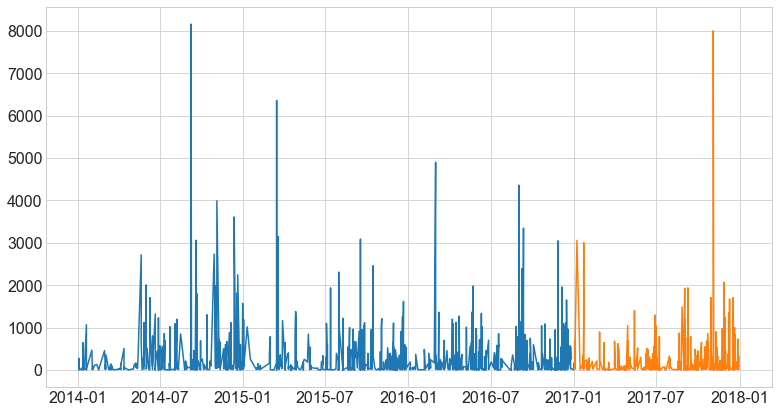

In [30]:
plt.plot(train.index, train.sales)
plt.plot(test.index, test.sales)

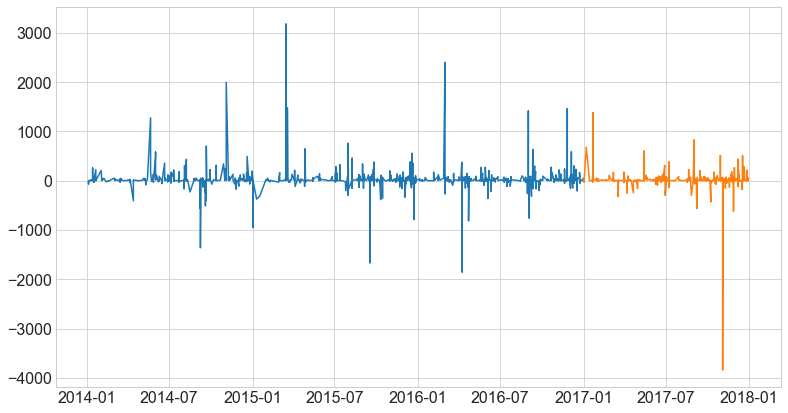

In [31]:
# profit
plt.plot(train.index, train.profit)
plt.plot(test.index, test.profit)

# Explore

In [32]:
# target as sales
y_sales = train.sales
y_sales.head()

order_date
2014-01-04     11.784
2014-01-04    272.736
2014-01-04      3.540
2014-01-09     31.200
2014-01-09      9.344
Name: sales, dtype: float64

In [33]:
# target as profit
y_profit = train.profit
y_profit.head()


order_date
2014-01-04     4.2717
2014-01-04   -64.7748
2014-01-04    -5.4870
2014-01-09     9.7500
2014-01-09     1.1680
Name: profit, dtype: float64

# Histogram plots

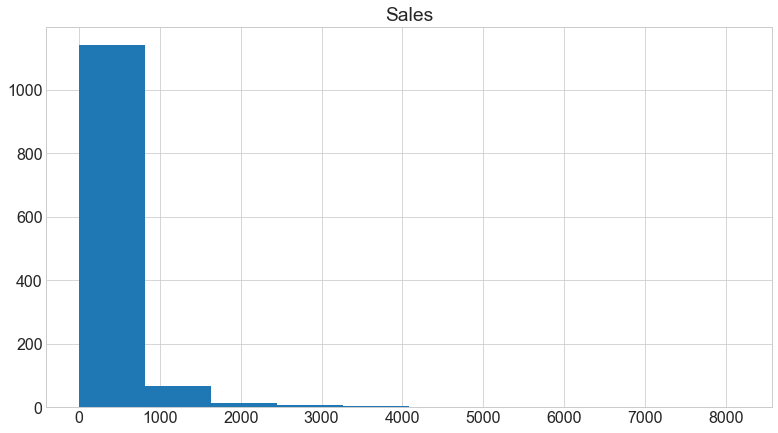

In [34]:
ax = y_sales.hist()
ax.set(title='Sales');

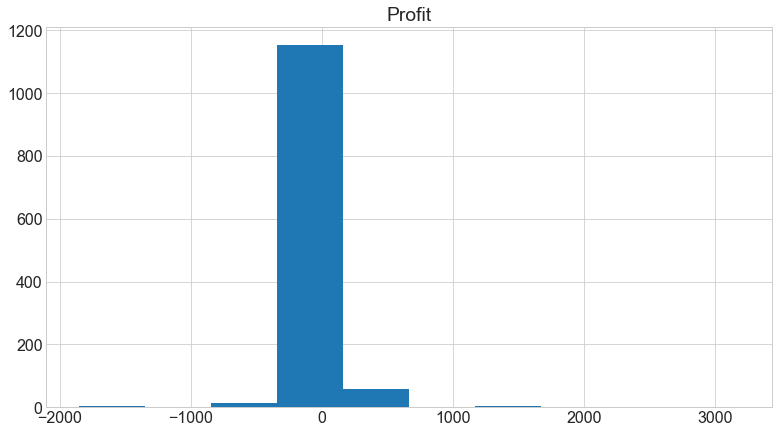

In [35]:
ax2 = y_profit.hist()
ax2.set(title='Profit');

# Average by Month

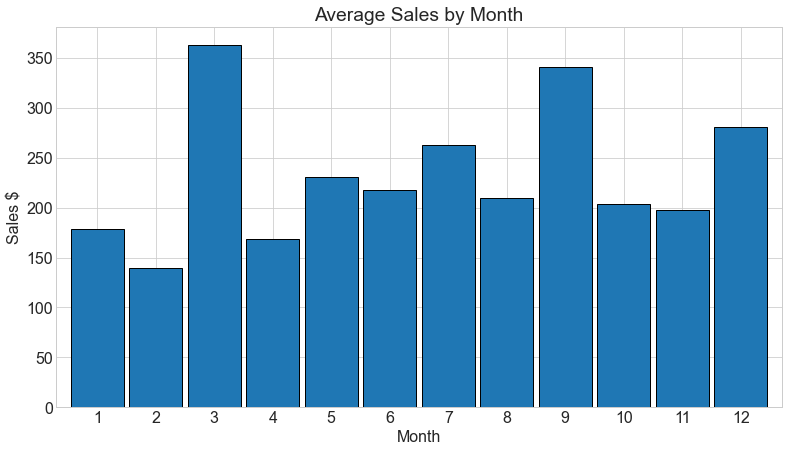

In [36]:
ax = y_sales.groupby(y_sales.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Month', xlabel='Month', ylabel='Sales $');

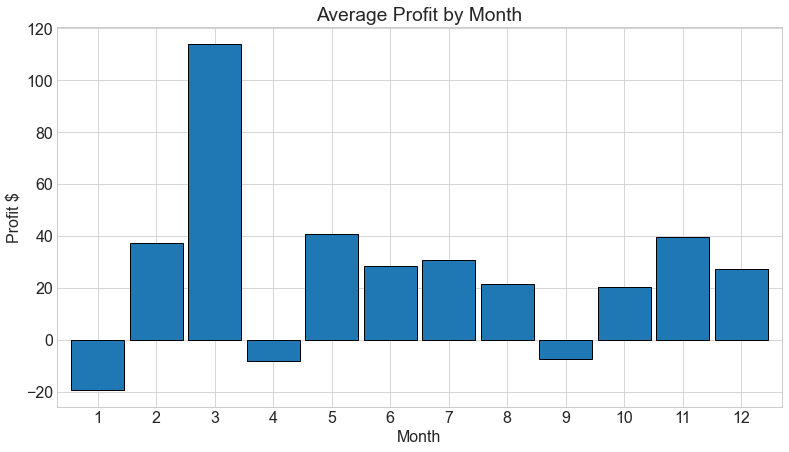

In [37]:
ax2 = y_profit.groupby(y_profit.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax2.set(title='Average Profit by Month', xlabel='Month', ylabel='Profit $');

# Average by Day

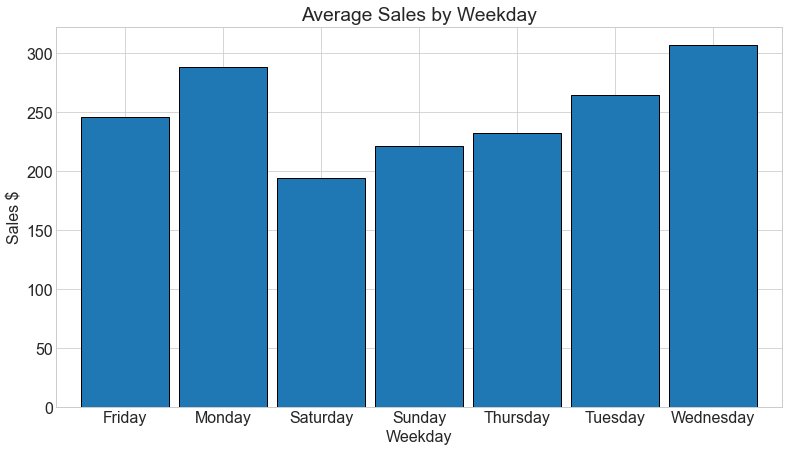

In [38]:
ax = y_sales.groupby(y_sales.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Weekday', xlabel='Weekday', ylabel='Sales $');


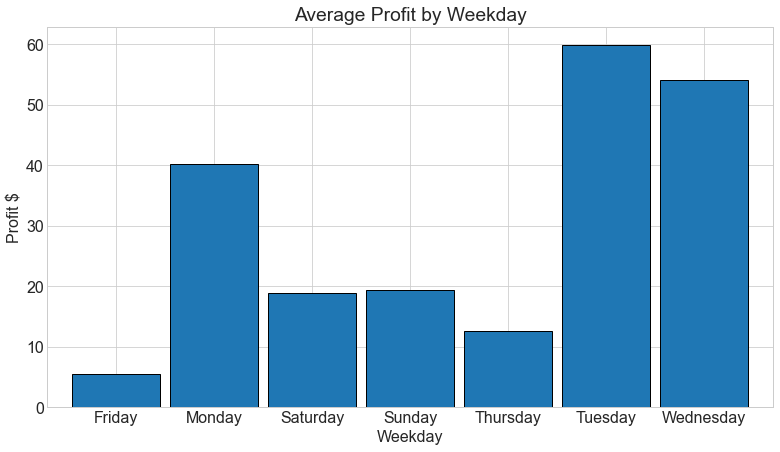

In [39]:
ax2 = y_profit.groupby(y_profit.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax2.set(title='Average Profit by Weekday', xlabel='Weekday', ylabel='Profit $');

In [40]:
y_sales

order_date
2014-01-04     11.784
2014-01-04    272.736
2014-01-04      3.540
2014-01-09     31.200
2014-01-09      9.344
               ...   
2016-12-24    540.048
2016-12-24     27.882
2016-12-26     33.900
2016-12-31      3.640
2016-12-31    159.768
Name: sales, Length: 1238, dtype: float64

# Boxplots Sales

<AxesSubplot:xlabel='day', ylabel='sales'>

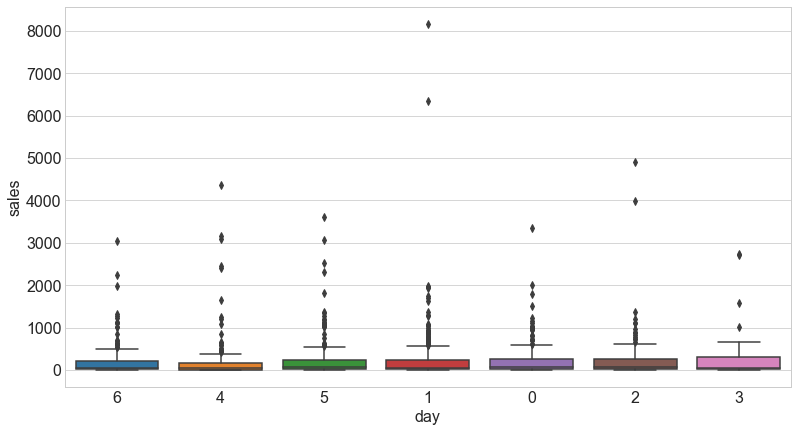

In [41]:
sns.boxplot(data = train, x = 'day', y = 'sales')

<AxesSubplot:xlabel='month', ylabel='sales'>

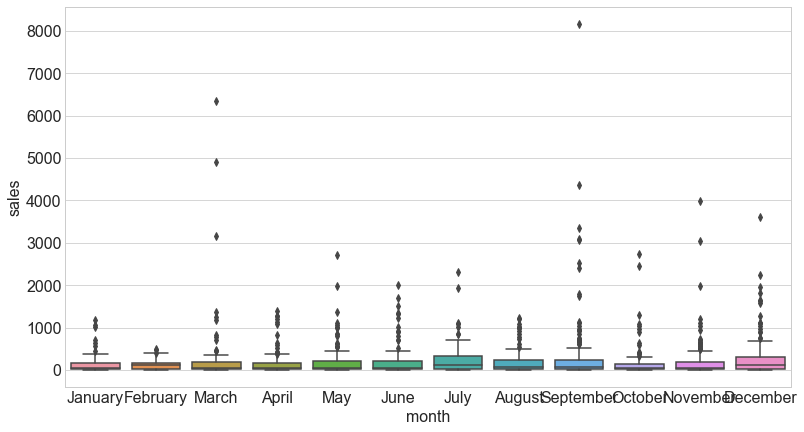

In [42]:
sns.boxplot(data = train, x= 'month', y = 'sales')

<AxesSubplot:xlabel='year', ylabel='sales'>

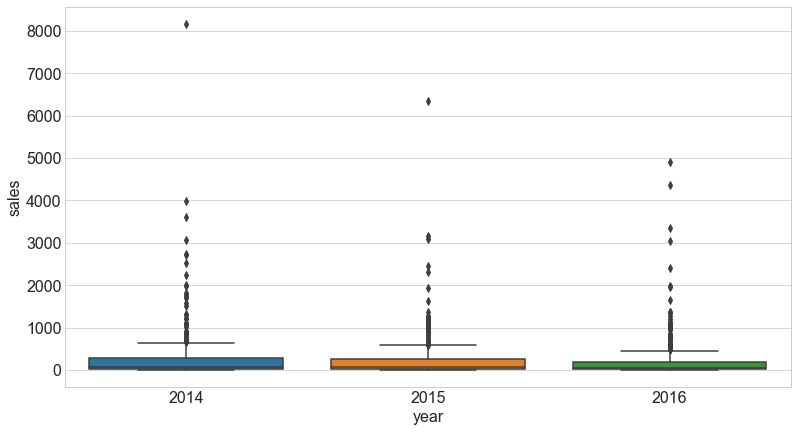

In [43]:
sns.boxplot(data = train, x = 'year', y = 'sales')

# Boxplot Profit

<AxesSubplot:xlabel='day', ylabel='profit'>

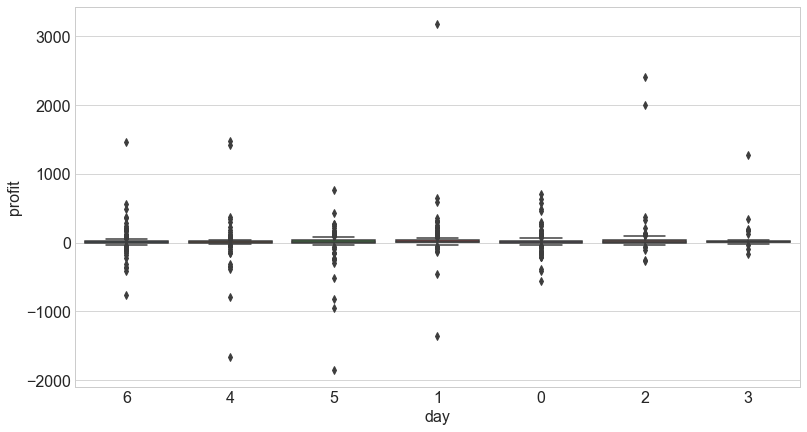

In [44]:
sns.boxplot(data = train, x= 'day', y = 'profit')

<AxesSubplot:xlabel='month', ylabel='profit'>

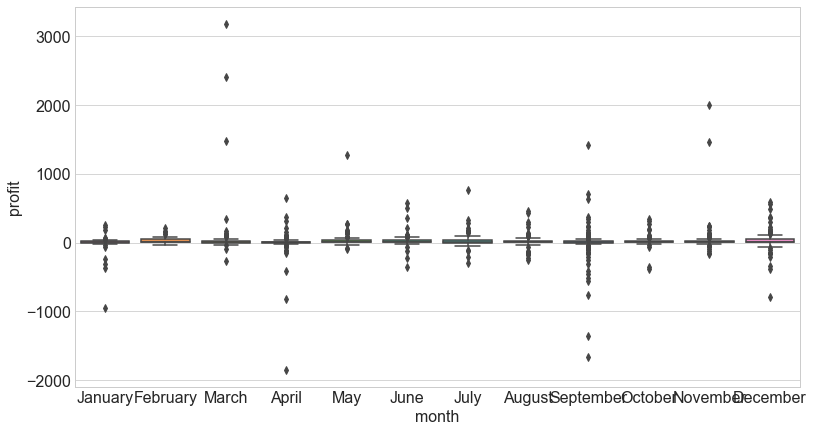

In [45]:
sns.boxplot(data = train, x= 'month', y = 'profit')

<AxesSubplot:xlabel='year', ylabel='profit'>

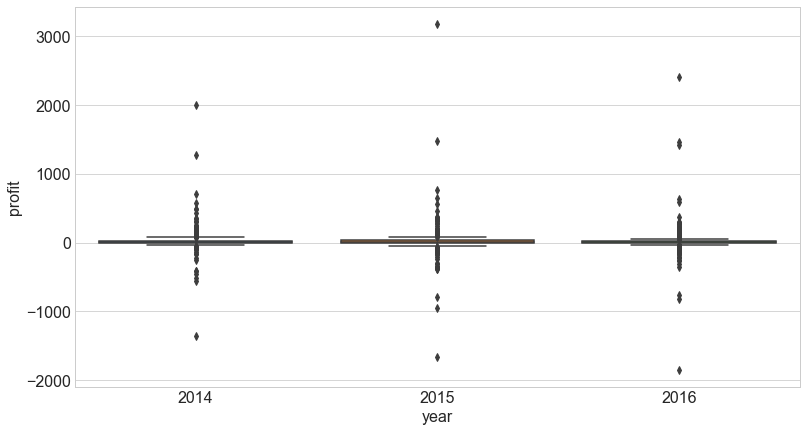

In [46]:
sns.boxplot(data = train, x= 'year', y = 'profit')

# Visualize Sales over time

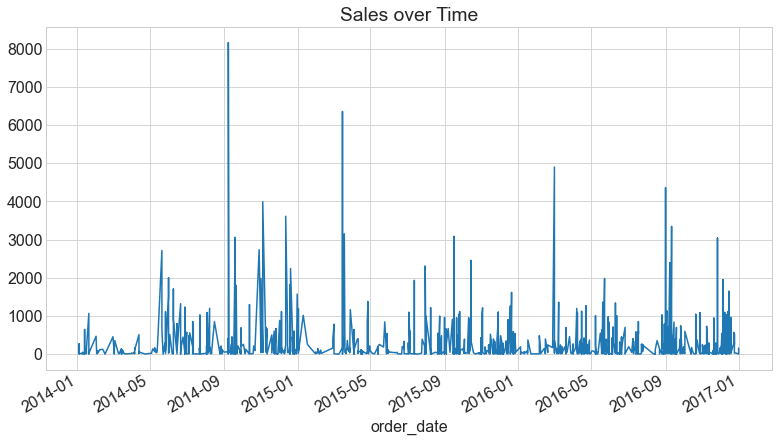

In [47]:
ax = y_sales.plot()
ax.set(title='Sales over Time');

<AxesSubplot:title={'center':'daily average'}, xlabel='order_date'>

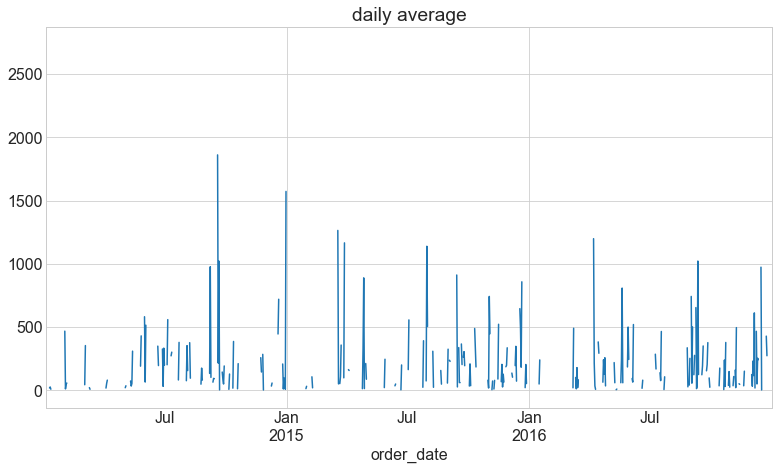

In [48]:
y_sales.resample('D').mean().plot(title='daily average')

<AxesSubplot:title={'center':'2 week average'}, xlabel='order_date'>

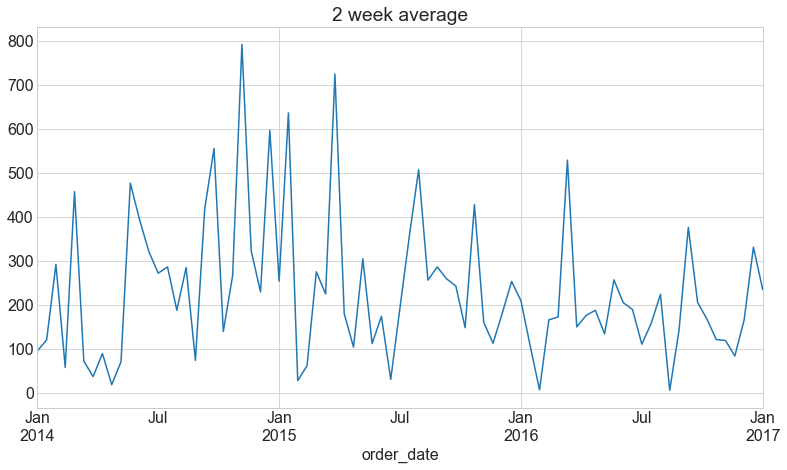

In [49]:
y_sales.resample('2W').mean().plot(title='2 week average')

<AxesSubplot:title={'center':'Monthly average'}, xlabel='order_date'>

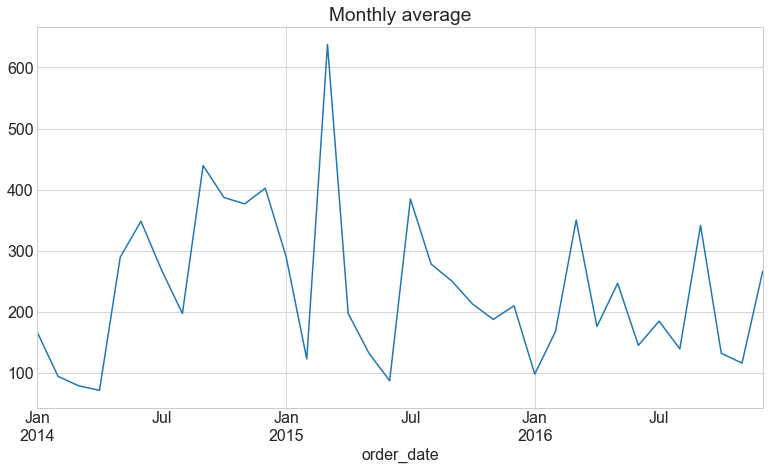

In [50]:
y_sales.resample('m').mean().plot(title='Monthly average')

<AxesSubplot:title={'center':'Yearly average'}, xlabel='order_date'>

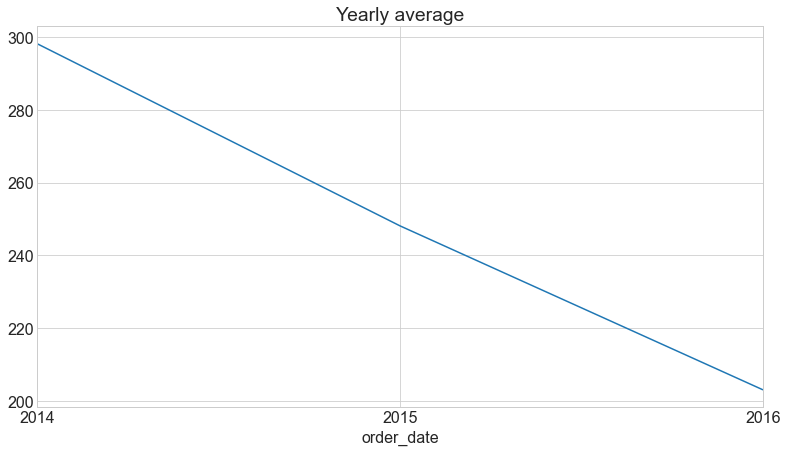

In [51]:
y_sales.resample('y').mean().plot(title='Yearly average')

# Visualize Profit Over time

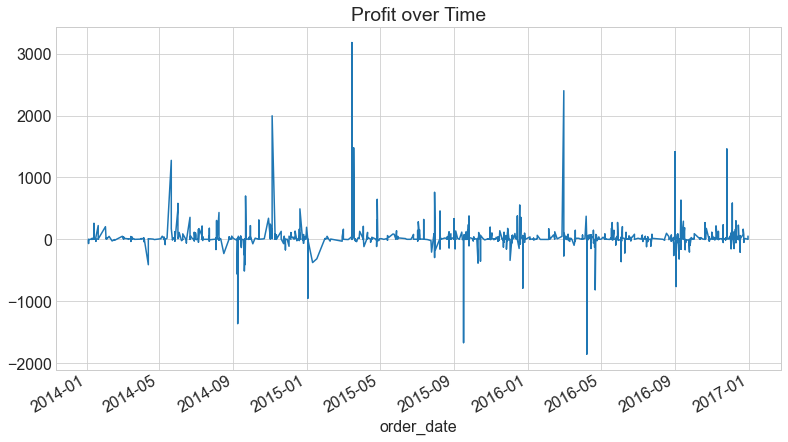

In [52]:
ax2 = y_profit.plot()
ax2.set(title='Profit over Time');

<AxesSubplot:title={'center':'daily average'}, xlabel='order_date'>

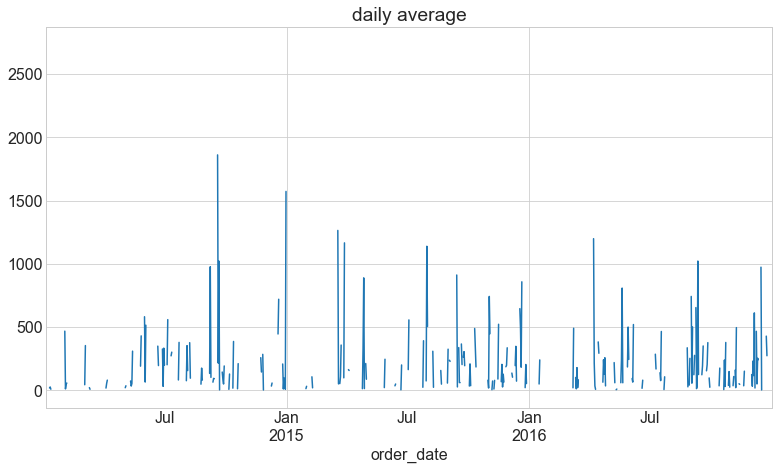

In [53]:
y_sales.resample('D').mean().plot(title='daily average')

<AxesSubplot:title={'center':'Weekly average'}, xlabel='order_date'>

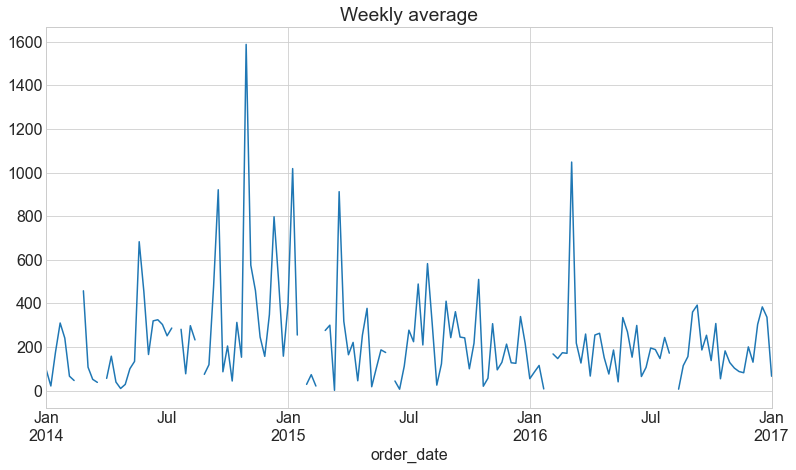

In [54]:
y_sales.resample('W').mean().plot(title='Weekly average')

<AxesSubplot:title={'center':'2 Weeks average'}, xlabel='order_date'>

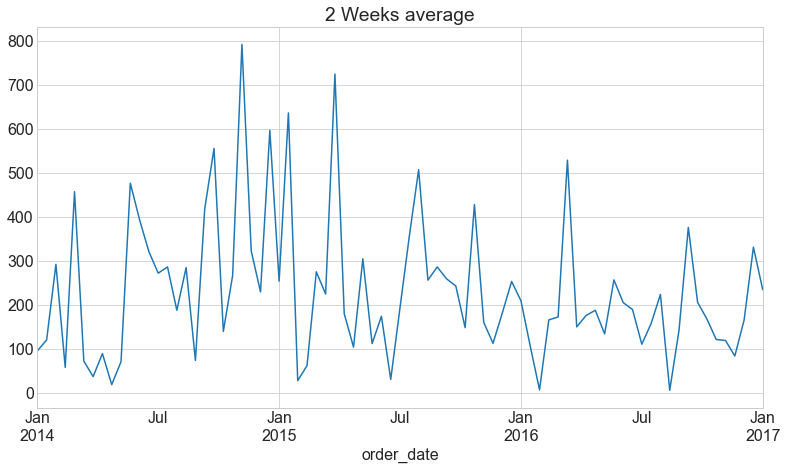

In [55]:
y_sales.resample('2W').mean().plot(title='2 Weeks average')

<AxesSubplot:title={'center':'Monthly average'}, xlabel='order_date'>

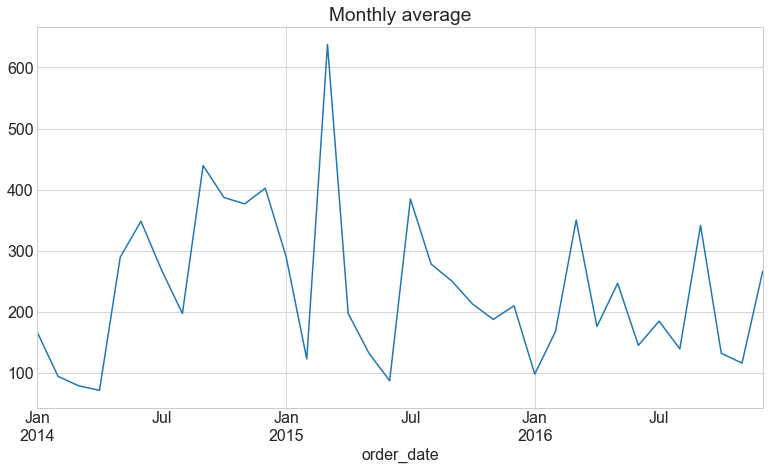

In [56]:
y_sales.resample('M').mean().plot(title='Monthly average')

<AxesSubplot:title={'center':'Yearly average'}, xlabel='order_date'>

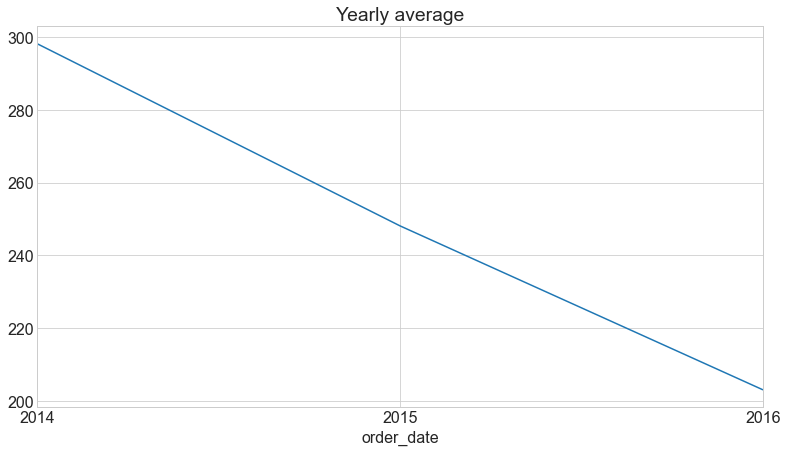

In [57]:
y_sales.resample('Y').mean().plot(title='Yearly average')

# Seasonal Plot

<AxesSubplot:title={'center':'Sales Seasonal Plot'}, xlabel='order_date'>

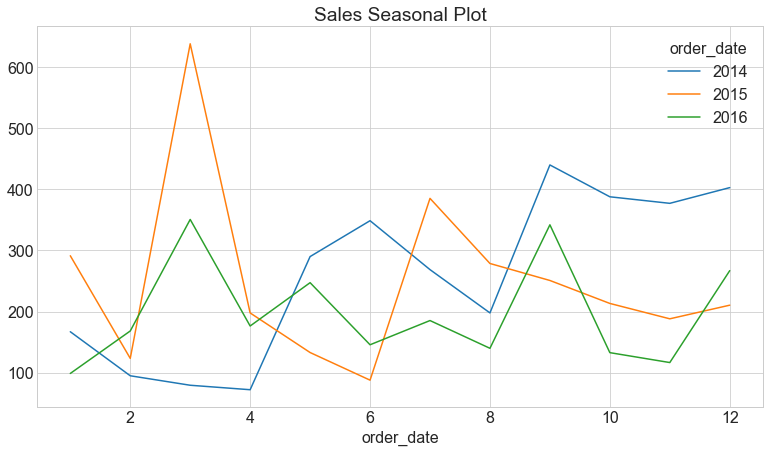

In [58]:
# .unstack turns an index level into columns
y_sales.groupby([y_sales.index.year, y_sales.index.month]).mean().unstack(0).plot(title='Sales Seasonal Plot')


<AxesSubplot:title={'center':'Profit Seasonal Plot'}, xlabel='order_date'>

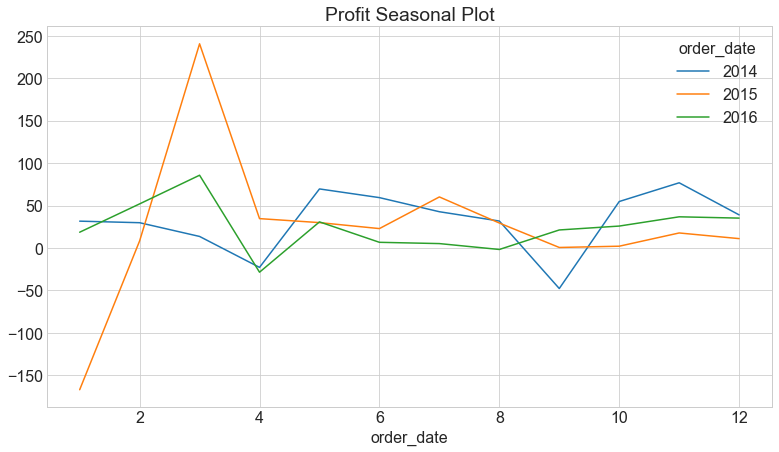

In [59]:
# .unstack turns an index level into columns
y_profit.groupby([y_profit.index.year, y_profit.index.month]).mean().unstack(0).plot(title='Profit Seasonal Plot')


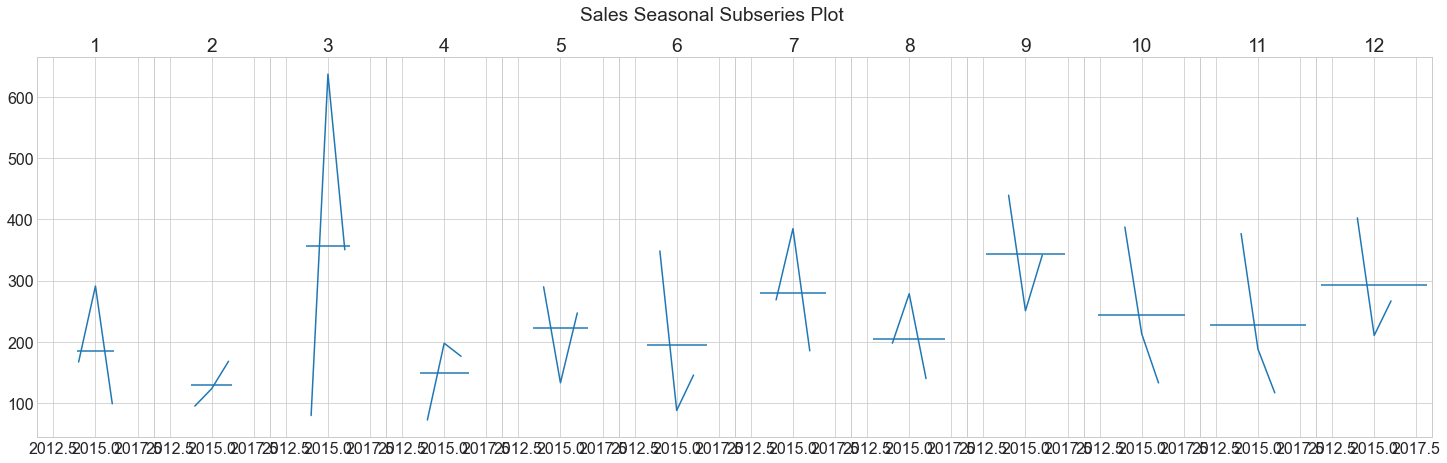

In [60]:
table = y_sales.groupby([y_sales.index.year, y_sales.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize = (25,7))
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Sales Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

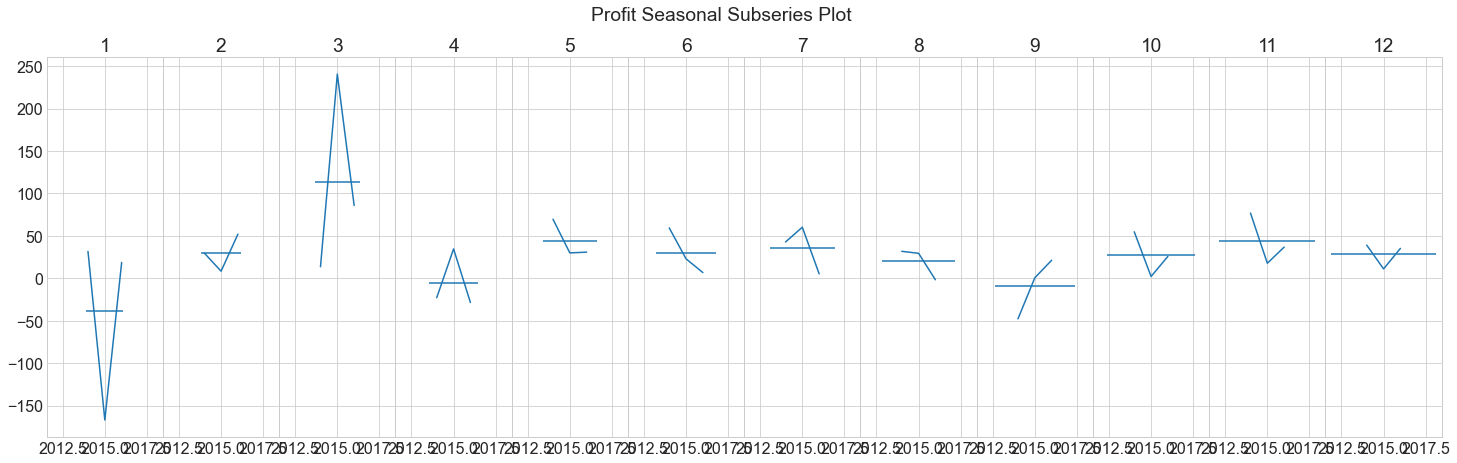

In [61]:
table = y_profit.groupby([y_profit.index.year, y_profit.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize = (25,7))
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Profit Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

# Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

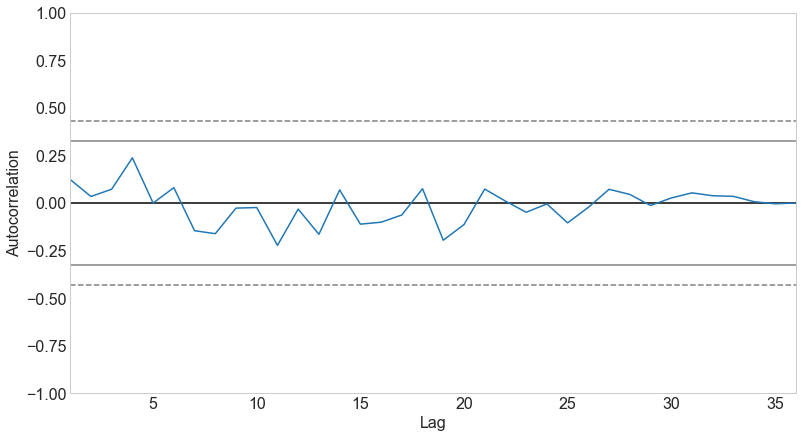

In [62]:
pd.plotting.autocorrelation_plot(y_sales.resample('m').mean())


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

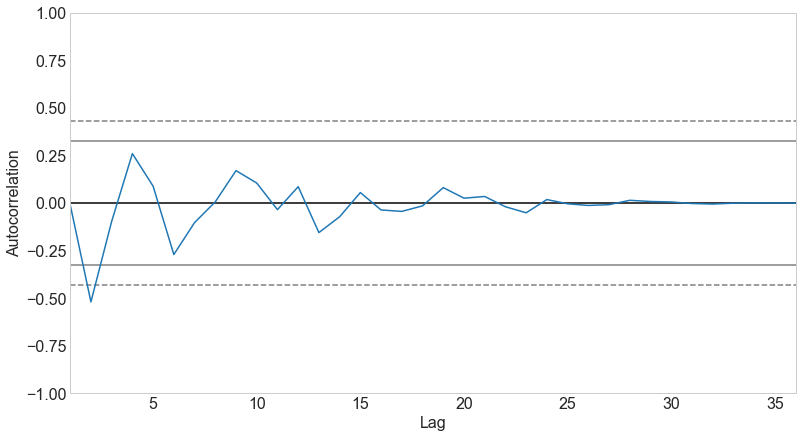

In [63]:
pd.plotting.autocorrelation_plot(y_profit.resample('m').mean())

# Decomposition for Sales

In [64]:
y = train.sales.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
order_date,,,,
2014-01-31,166.956435,NaN,-70.809738,NaN
2014-02-28,94.946600,NaN,-117.042601,NaN
2014-03-31,79.443619,NaN,234.554448,NaN
2014-04-30,72.133125,NaN,-65.236197,NaN
2014-05-31,289.827120,NaN,-51.442460,NaN


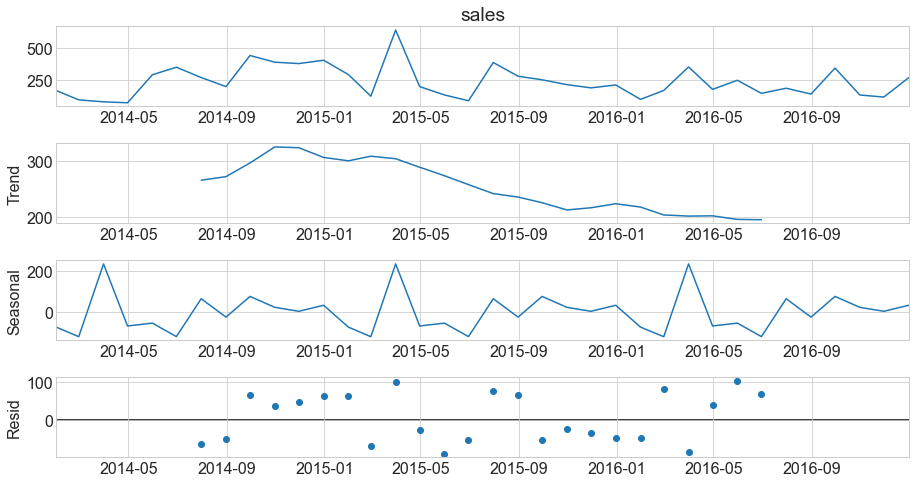

In [65]:
result.plot()
None

# Decomposition for Profit

In [66]:
y2 = train.profit.resample('M').mean()

result2 = sm.tsa.seasonal_decompose(y2)
decomposition2 = pd.DataFrame({
    'y2': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition2.head()

,y2,trend,seasonal,resid
order_date,,,,
2014-01-31,166.956435,NaN,-70.809738,NaN
2014-02-28,94.946600,NaN,-117.042601,NaN
2014-03-31,79.443619,NaN,234.554448,NaN
2014-04-30,72.133125,NaN,-65.236197,NaN
2014-05-31,289.827120,NaN,-51.442460,NaN


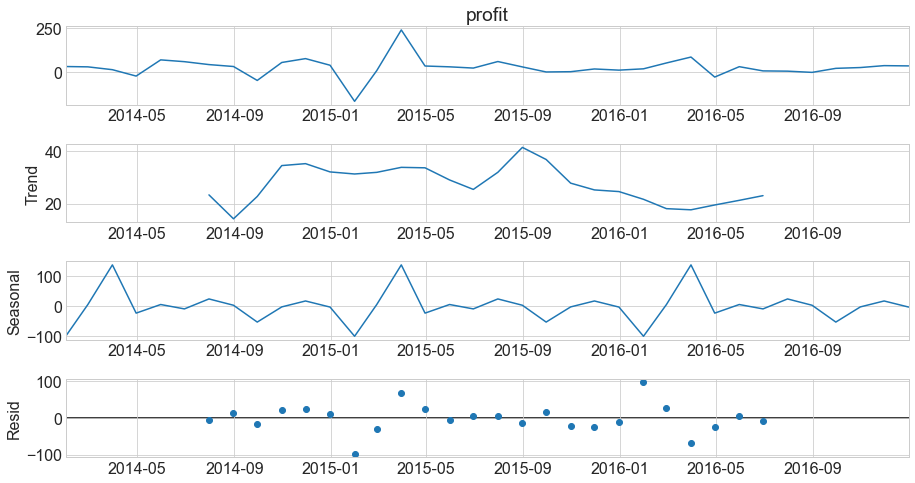

In [67]:
result2.plot()
None

# Focus on Sales of Office Supplies, Furniture and Technology

In [68]:
df.head()

,ship_mode,segment,country,city,state,postal_code,sales,quantity,discount,profit,customer_name,product_name,category,sub_category,region_name,month,year,day
order_date,,,,,,,,,,,,,,,,,,
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,11.784,3.0,0.2,4.2717,Phillina Ober,Avery 508,Office Supplies,Labels,Central,January,2014,6
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,272.736,3.0,0.2,-64.7748,Phillina Ober,SAFCO Boltless Steel Shelving,Office Supplies,Storage,Central,January,2014,6
2014-01-04,Standard Class,Home Office,United States,Naperville,Illinois,60540.0,3.540,2.0,0.8,-5.4870,Phillina Ober,GBC Standard Plastic Binding Systems Combs,Office Supplies,Binders,Central,January,2014,6
2014-01-09,Standard Class,Consumer,United States,Laredo,Texas,78041.0,31.200,3.0,0.2,9.7500,Melanie Seite,Memorex Micro Travel Drive 8 GB,Technology,Accessories,Central,January,2014,4
2014-01-09,Standard Class,Consumer,United States,Laredo,Texas,78041.0,9.344,2.0,0.2,1.1680,Melanie Seite,Newell 312,Office Supplies,Art,Central,January,2014,4


In [69]:
office_supplies = train.loc[train['category']=='Office Supplies']
furniture = train.loc[train['category']=='Furniture']
technology = train.loc[train['category']=='Technology']

In [70]:
office_supplies.index.max(), office_supplies.index.min(),furniture.index.max(), furniture.index.min(),technology.index.max(), technology.index.min()

(Timestamp('2016-12-31 00:00:00'),
 Timestamp('2014-01-04 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2014-01-10 00:00:00'),
 Timestamp('2016-12-24 00:00:00'),
 Timestamp('2014-01-09 00:00:00'))

In [71]:
office_supplies.columns

Index(['ship_mode', 'segment', 'country', 'city', 'state', 'postal_code',
       'sales', 'quantity', 'discount', 'profit', 'customer_name',
       'product_name', 'category', 'sub_category', 'region_name', 'month',
       'year', 'day'],
      dtype='object')

In [72]:
exclude_columns = ['ship_mode', 'segment', 'country', 'city', 'state', 'postal_code',
        'quantity', 'discount', 'profit', 'customer_name',
       'product_name', 'category', 'sub_category', 'region_name', 'month',
       'year', 'day']

In [73]:
office_supplies.drop(exclude_columns, axis =1, inplace = True)
furniture.drop(exclude_columns, axis =1, inplace = True)
technology.drop(exclude_columns, axis =1, inplace = True)

/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/1863057702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office_supplies.drop(exclude_columns, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/1863057702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture.drop(exclude_columns, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/1863057702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [74]:
office_supplies_resample_monthstart= office_supplies.sales.resample('MS').mean()
furniture_resample_monthstart= furniture.sales.resample('MS').mean()
technology_resample_monthstart= technology.sales.resample('MS').mean()

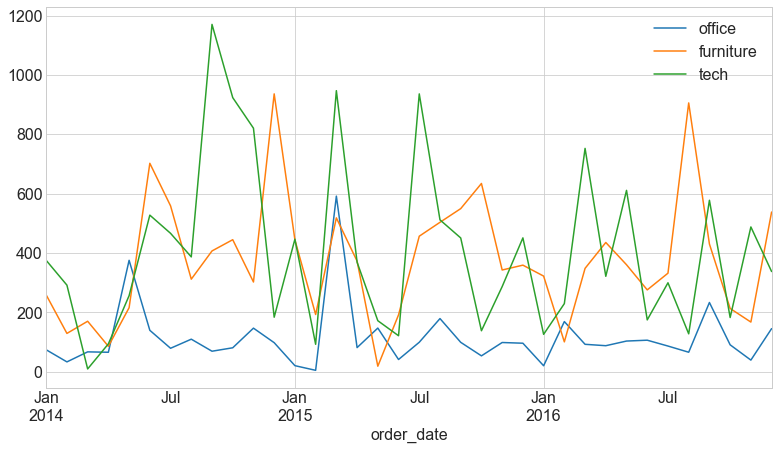

In [75]:

office_supplies_resample_monthstart.plot(sharey =True, label = 'office')
furniture_resample_monthstart.plot(sharey =True, label = 'furniture')
technology_resample_monthstart.plot(sharey =True, label = 'tech' )
plt.legend();

### Sales in technology and furniture are higher than sales in office supplies.
### technology seems to be seasonal, also to be reducing geometricaly

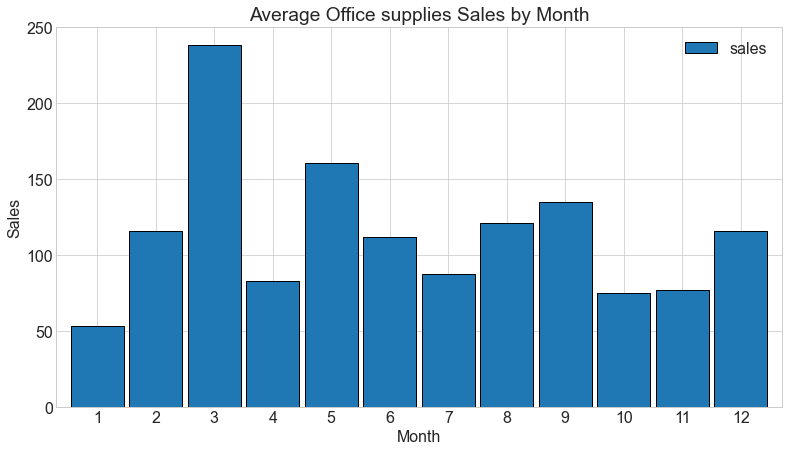

In [76]:
ax1 = office_supplies.groupby(office_supplies.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax1.set(title='Average Office supplies Sales by Month', xlabel='Month', ylabel='Sales');

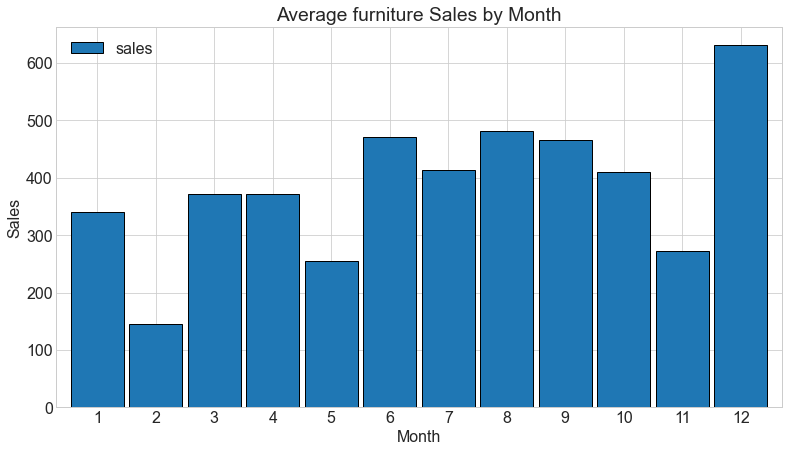

In [77]:
ax2 = furniture.groupby(furniture.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax2.set(title='Average furniture Sales by Month', xlabel='Month', ylabel='Sales');

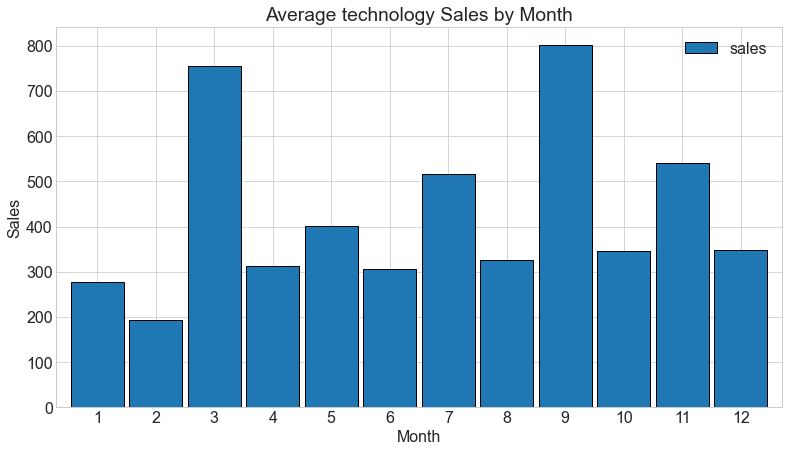

In [78]:
ax3 = technology.groupby(technology.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax3.set(title='Average technology Sales by Month', xlabel='Month', ylabel='Sales');

# Focus on Profit of Office Supplies, Furniture and Technology

In [79]:
office_supplies2 = train.loc[train['category']=='Office Supplies']
furniture2 = train.loc[train['category']=='Furniture']
technology2 = train.loc[train['category']=='Technology']

In [80]:
office_supplies2.index.max(), office_supplies2.index.min(),furniture2.index.max(), furniture2.index.min(),technology2.index.max(), technology2.index.min()

(Timestamp('2016-12-31 00:00:00'),
 Timestamp('2014-01-04 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2014-01-10 00:00:00'),
 Timestamp('2016-12-24 00:00:00'),
 Timestamp('2014-01-09 00:00:00'))

In [81]:
office_supplies2.columns

Index(['ship_mode', 'segment', 'country', 'city', 'state', 'postal_code',
       'sales', 'quantity', 'discount', 'profit', 'customer_name',
       'product_name', 'category', 'sub_category', 'region_name', 'month',
       'year', 'day'],
      dtype='object')

In [82]:
exclude_columns2 = ['ship_mode', 'segment', 'country', 'city', 'state', 'postal_code',
        'sales','quantity', 'discount', 'customer_name',
       'product_name', 'category', 'sub_category', 'region_name', 'month',
       'year', 'day']

In [83]:
office_supplies2.drop(exclude_columns2, axis =1, inplace = True)
furniture2.drop(exclude_columns2, axis =1, inplace = True)
technology2.drop(exclude_columns2, axis =1, inplace = True)

/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/438035186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office_supplies2.drop(exclude_columns2, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/438035186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture2.drop(exclude_columns2, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/438035186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [84]:
office_supplies_resample_monthstart2= office_supplies2.profit.resample('MS').mean()
furniture_resample_monthstart2= furniture2.profit.resample('MS').mean()
technology_resample_monthstart2= technology2.profit.resample('MS').mean()

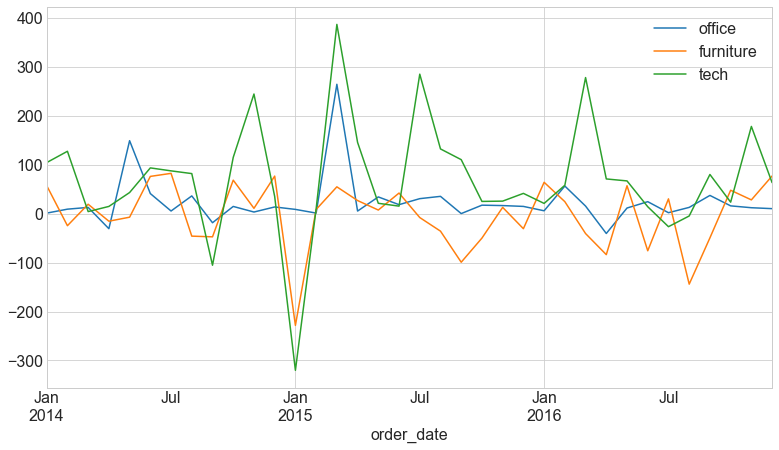

In [85]:

office_supplies_resample_monthstart2.plot(sharey =True, label = 'office')
furniture_resample_monthstart2.plot(sharey =True, label = 'furniture')
technology_resample_monthstart2.plot(sharey =True, label = 'tech' )
plt.legend();

### Technology seems to be the most profitable from all the categories and furniture seems to be the least profitable.

### technology seems to be seasonal

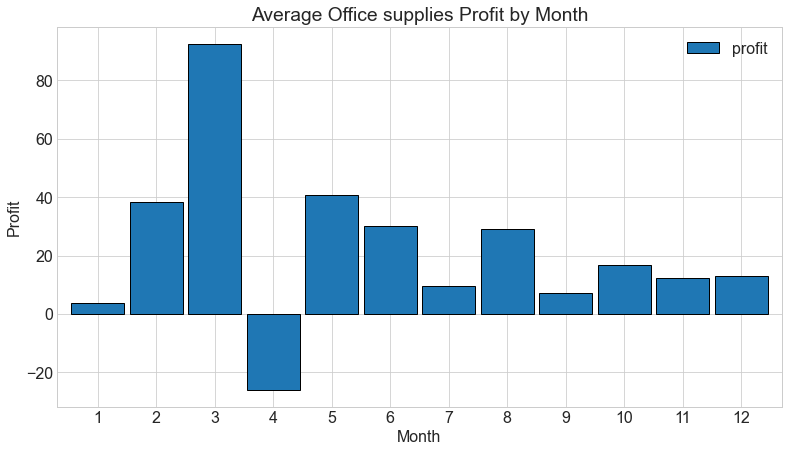

In [86]:
ax = office_supplies2.groupby(office_supplies2.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Office supplies Profit by Month', xlabel='Month', ylabel='Profit');

### Office supplies are most profitable on March. It is negative one month of the year on April.

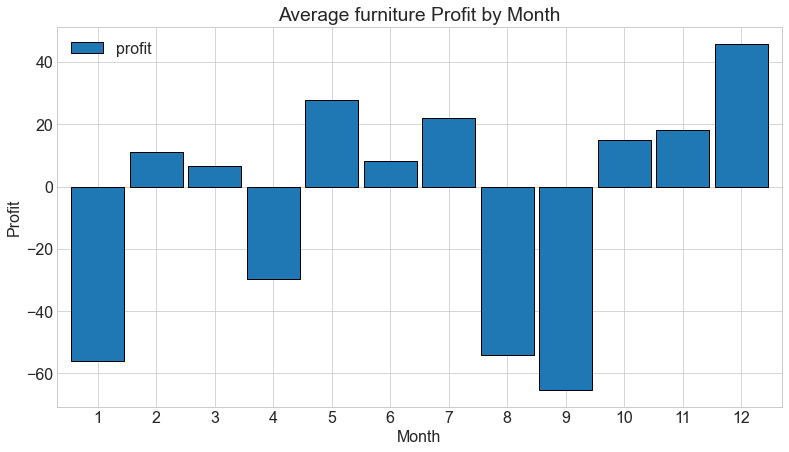

In [87]:
ax = furniture2.groupby(furniture2.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average furniture Profit by Month', xlabel='Month', ylabel='Profit');

### Furniture is more profitable in December. It is negative 4 months out of the year

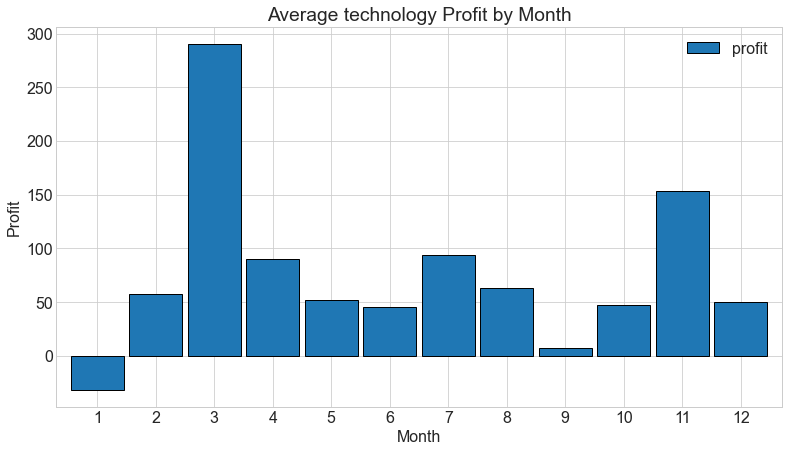

In [88]:
ax = technology2.groupby(technology2.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average technology Profit by Month', xlabel='Month', ylabel='Profit');

### Technology is more profitable on the month of march and stays in positive numbers 11 months of the year.

# Focus on diffirent regions

In [89]:
train.columns

Index(['ship_mode', 'segment', 'country', 'city', 'state', 'postal_code',
       'sales', 'quantity', 'discount', 'profit', 'customer_name',
       'product_name', 'category', 'sub_category', 'region_name', 'month',
       'year', 'day'],
      dtype='object')

In [90]:
train.region_name.value_counts()

East       396
West       395
Central    264
South      183
Name: region_name, dtype: int64

In [91]:
# create sub categories by region
east_region = train.loc[train['region_name']=='East']
west_region = train.loc[train['region_name']=='West']
central_region = train.loc[train['region_name']=='Central']
south_region = train.loc[train['region_name']=='South']


In [92]:
# exclude all columns except sales and date index
east_region.drop(exclude_columns, axis =1, inplace = True)
west_region.drop(exclude_columns, axis =1, inplace = True)
central_region.drop(exclude_columns, axis =1, inplace = True)
south_region.drop(exclude_columns, axis =1, inplace = True)

/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/136966687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  east_region.drop(exclude_columns, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/136966687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_region.drop(exclude_columns, axis =1, inplace = True)
/var/folders/gl/sb_qsbtn2n58skm07d4xzbwh0000gn/T/ipykernel_6604/136966687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

<AxesSubplot:xlabel='order_date'>

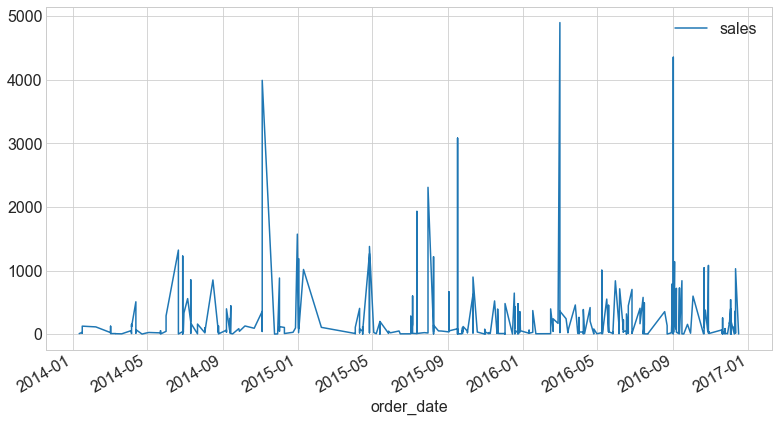

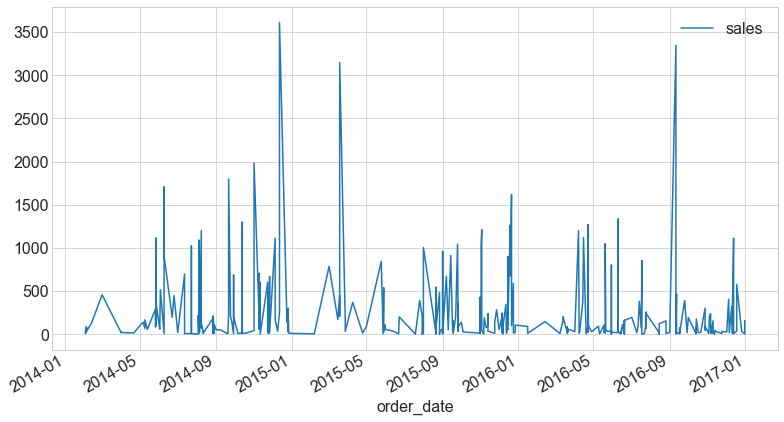

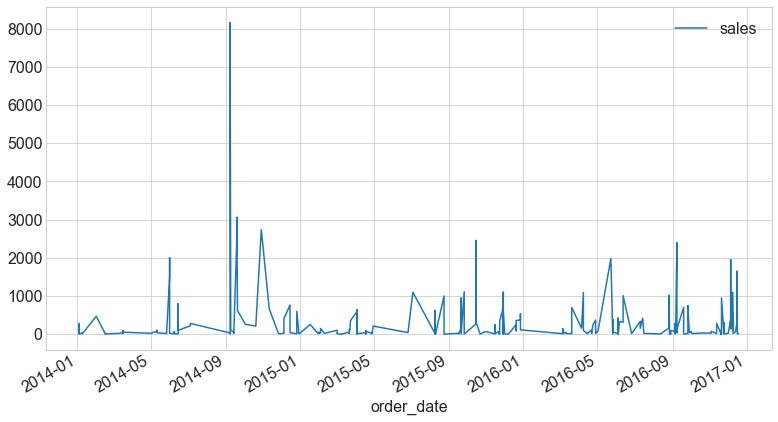

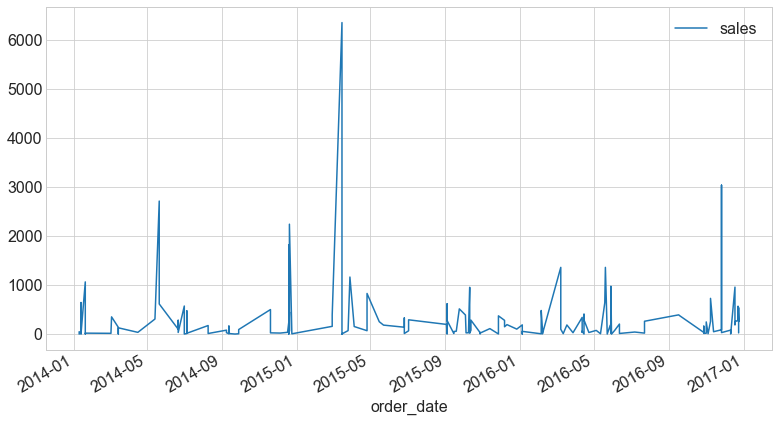

In [93]:
east_region.plot()
west_region.plot()
central_region.plot()
south_region.plot()

# resample regions by month

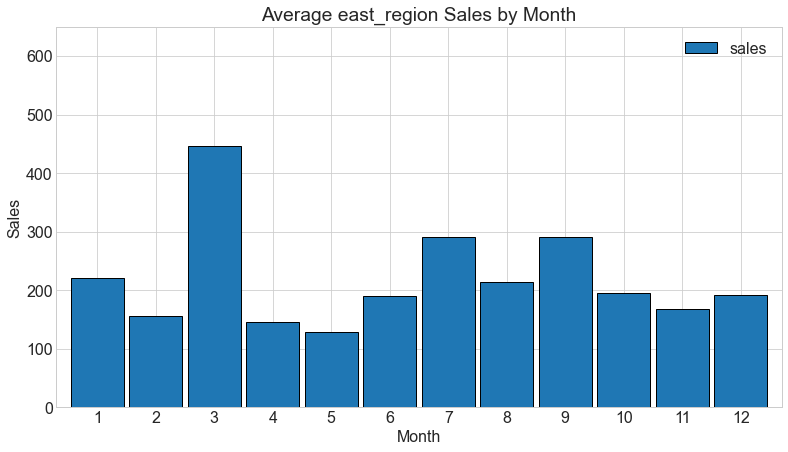

In [125]:
ax = east_region.groupby(east_region.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average east_region Sales by Month', xlabel='Month', ylabel='Sales')
ax.set_ylim(0, 650);

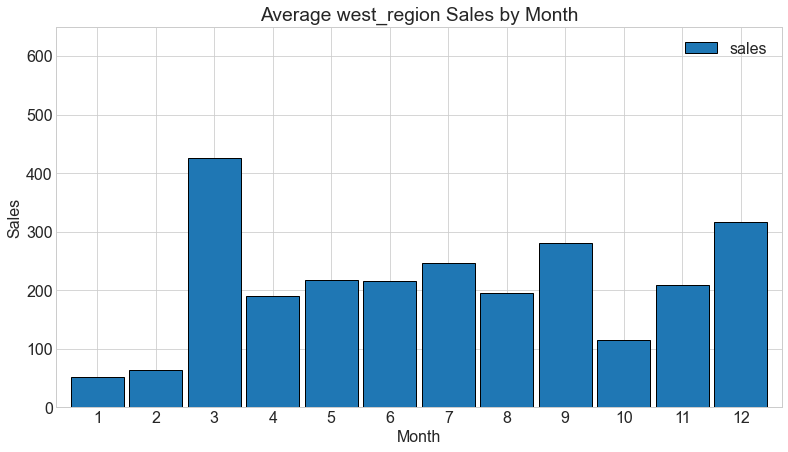

In [124]:
ax2 = west_region.groupby(west_region.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax2.set(title='Average west_region Sales by Month', xlabel='Month', ylabel='Sales')
ax2.set_ylim(0, 650);

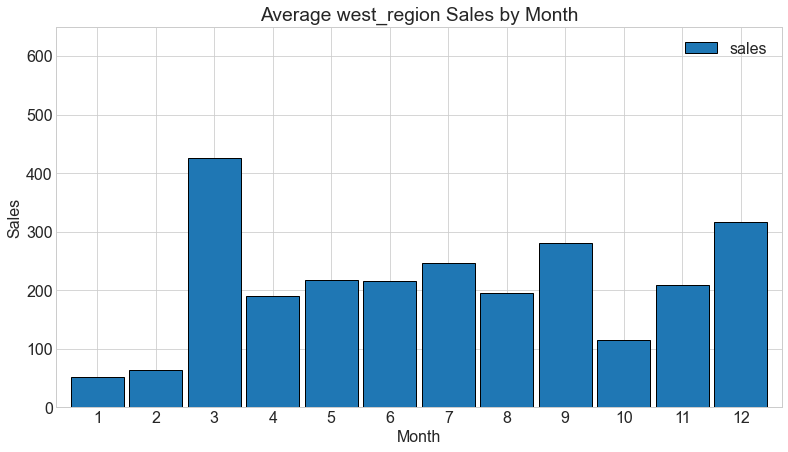

In [123]:
ax1 = west_region.groupby(west_region.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax1.set(title='Average west_region Sales by Month', xlabel='Month', ylabel='Sales')
ax1.set_ylim(0, 650);

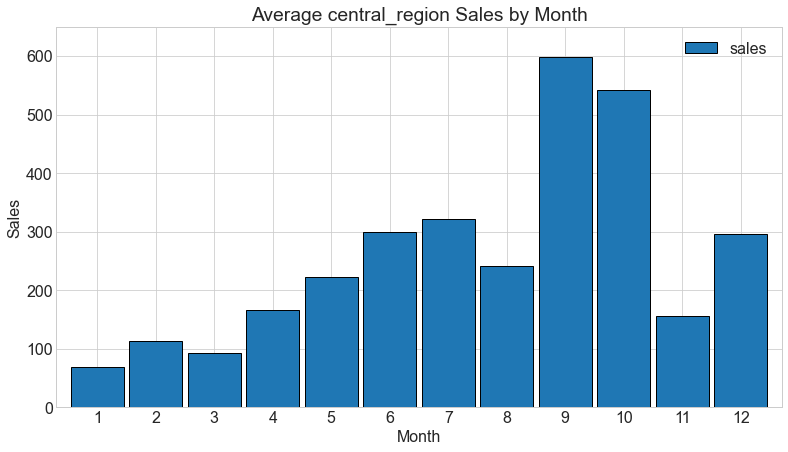

In [122]:
ax1 = central_region.groupby(central_region.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax1.set(title='Average central_region Sales by Month', xlabel='Month', ylabel='Sales')
ax1.set_ylim(0, 650);

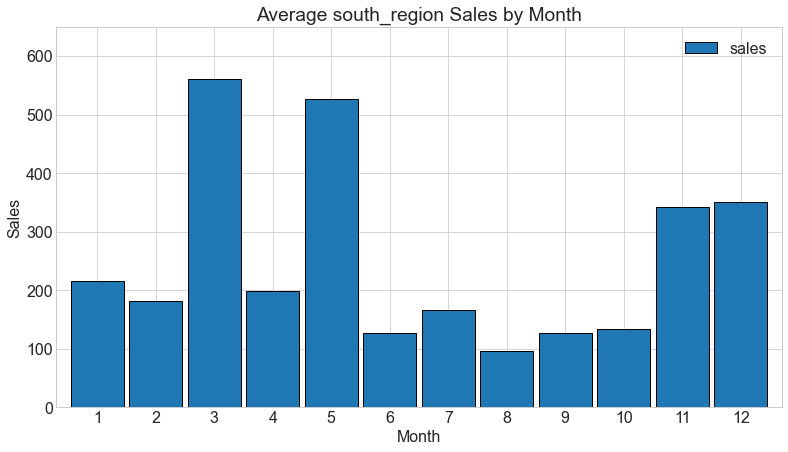

In [128]:
ax1 = south_region.groupby(south_region.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax1.set(title='Average south_region Sales by Month', xlabel='Month', ylabel='Sales')
ax1.set_ylim(0, 650);